# Simple Interactive Analysis in Tornasole
This notebook will demonstrate the simplest kind of interactive analysis that can be run in Tornasole. It will focus on the [vanishing/exploding gradient](https://medium.com/learn-love-ai/the-curious-case-of-the-vanishing-exploding-gradient-bf58ec6822eb) problems on a simple MNIST digit recognition.

## Setup

Some basic setup that's always helpful

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Make sure that MXNet is accessible! If you are on the EC2 Deep Learning AMI, you will probably want
to activate the right MXNet environment
```
sh> source activate mxnet_p36
```
You'll probably have to restart this notebook after doing this

Let's import some basic libraries for ML

In [11]:
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon import nn
import matplotlib.pyplot as plt

Let's copy the Tornasole libraries to this instance, this step has to be executed only once. 
Please make sure that the AWS account you are using can access the `tornasole-binaries-use1` bucket.

To do so you'll need the appropriate AWS credentials. There are several ways of doing this:
- inject temporary credentials 
- if running on EC2, use [EC2 roles](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles_use_switch-role-ec2.html) that can access all S3 buckets
- (preferred) run this notebook on a [SageMaker notebook instance](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi.html)

The code below downloads the necessary `.whl` files and installs them in the current environment. Only run the first time!


In [12]:
#WARNING - uncomment this code only if you haven't done this before
#!aws s3 sync s3://tornasole-binaries-use1/tornasole_mxnet/py3/latest/ tornasole_mxnet/
#!pip install tornasole_mxnet/*

# If you run into a version conflict with boto, run the following
# !pip uninstall -y botocore boto3 aioboto3 aiobotocore && pip install botocore==1.12.91 boto3==1.9.91 aiobotocore==0.10.2 aioboto3==6.4.1


## Model Training and Gradient Analysis
At this point we have all the ingredients installed on our machine. We can now start training.

The goal of this notebook is to show how to detect the Vanishing Gradient problem. We will first do it manually and then automatic.

In [13]:
from tornasole.mxnet import TornasoleHook, SaveConfig
from tornasole.trials import LocalTrial

We can change the logging level if appropriate 

In [14]:
#import logging
#logging.getLogger("tornasole").setLevel(logging.WARNING)

We can define a simple network - it doesn't really matter what it is.
Importantly - we **add the Tornasole Hook**. This hook will be run at every batch and will save selected tensors (in this case, all of them) to the desired directory (in this case, `'{base_loc}/{run_id}'`.

`{base_loc}` can be either a path on a local file system (for instance, `./ts_output/`) or an S3 bucket/object (`s3://mybucket/myprefix/`).

See the documentation for more details.

In [15]:
def create_net( tornasole_save_interval, base_loc, run_id ):
    net = nn.Sequential()
    with net.name_scope():
        net.add(nn.Dense(128, activation='relu'))
        net.add(nn.Dense(64, activation='relu'))
        net.add(nn.Dense(10))

    # Create and add the hook. Arguments:
    # - save data in './{base_loc}/{run_id} - Note: s3 is also supported
    # - save every 100 batches
    # - save every tensor: inputs/outputs to each layer, as well as gradients
    trial_dir = base_loc + run_id
    hook = TornasoleHook(out_dir=trial_dir,
                     save_config=SaveConfig(save_interval=100), 
                     save_all=True)
    hook.register_hook(net)
    return net

And we create a simple training script. No Tornasole-specific code here, this is a slightly modified version of the [digit recognition](https://github.com/apache/incubator-mxnet/blob/master/example/gluon/mnist/mnist.py) example on the MXNet website.

In [16]:
def transformer(data, label):
    data = data.reshape((-1,)).astype(np.float32)/255
    return data, label

def test(ctx, val_data):
    metric = mx.metric.Accuracy()
    for data, label in val_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        metric.update([label], [output])

    return metric.get()


def train(net, epochs, ctx, learning_rate, momentum):
    train_data = gluon.data.DataLoader(
        gluon.data.vision.MNIST('./data', train=True, transform=transformer),
        batch_size=100, shuffle=True, last_batch='discard')

    val_data = gluon.data.DataLoader(
        gluon.data.vision.MNIST('./data', train=False, transform=transformer),
        batch_size=100, shuffle=False)
    
    # Collect all parameters from net and its children, then initialize them.
    net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    # Trainer is for updating parameters with gradient.
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': learning_rate, 'momentum': momentum})
    metric = mx.metric.Accuracy()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()

    for epoch in range(epochs):
        # reset data iterator and metric at begining of epoch.
        metric.reset()
        for i, (data, label) in enumerate(train_data):
            # Copy data to ctx if necessary
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # Start recording computation graph with record() section.
            # Recorded graphs can then be differentiated with backward.
            with autograd.record():
                output = net(data)
                L = loss(output, label)
                L.backward()
            # take a gradient step with batch_size equal to data.shape[0]
            trainer.step(data.shape[0])
            # update metric at last.
            metric.update([label], [output])

            if i % 100 == 0 and i > 0:
                name, acc = metric.get()
                print('[Epoch %d Batch %d] Training: %s=%f'%(epoch, i, name, acc))

        name, acc = metric.get()
        print('[Epoch %d] Training: %s=%f'%(epoch, name, acc))

        name, val_acc = test(ctx, val_data)
        print('[Epoch %d] Validation: %s=%f'%(epoch, name, val_acc))

    net.save_parameters('mnist.params')




Clear up from previous runs, we remove old data (warning - we assume that we have set `ts_output` as the directory into which we send data)

In [17]:
!rm -rf ./ts_output/

At this point we are ready to train. We will train this simple model.

For the purposes of this example, we will name this run as `'good'` because we know it will converge to a good solution.  If you have a GPU on your machine, you can change `ctx=mx.gpu(0)`.

Behind the scenes, the `TornasoleHook` is saving the data requested.

In [18]:
net = create_net( tornasole_save_interval=100, base_loc='./ts_output/', run_id='good')
train(net=net, epochs=4, ctx=mx.cpu(), learning_rate=0.1, momentum=0.9)

[Epoch 0 Batch 100] Training: accuracy=0.799406
[Epoch 0 Batch 200] Training: accuracy=0.859552
[Epoch 0 Batch 300] Training: accuracy=0.886047
[Epoch 0 Batch 400] Training: accuracy=0.899127
[Epoch 0 Batch 500] Training: accuracy=0.909840
[Epoch 0] Training: accuracy=0.917400
[Epoch 0] Validation: accuracy=0.956400
[Epoch 1 Batch 100] Training: accuracy=0.962178
[Epoch 1 Batch 200] Training: accuracy=0.963234
[Epoch 1 Batch 300] Training: accuracy=0.963555
[Epoch 1 Batch 400] Training: accuracy=0.964489
[Epoch 1 Batch 500] Training: accuracy=0.963653
[Epoch 1] Training: accuracy=0.964333
[Epoch 1] Validation: accuracy=0.963900
[Epoch 2 Batch 100] Training: accuracy=0.973267
[Epoch 2 Batch 200] Training: accuracy=0.972736
[Epoch 2 Batch 300] Training: accuracy=0.973123
[Epoch 2 Batch 400] Training: accuracy=0.973317
[Epoch 2 Batch 500] Training: accuracy=0.972894
[Epoch 2] Training: accuracy=0.973183
[Epoch 2] Validation: accuracy=0.971000
[Epoch 3 Batch 100] Training: accuracy=0.98049

## Data Analysis - Manual
Now that we have trained the system we can analyze the data. Notice that this notebook focuses on after-the-fact analysis. Tornasole also provides a collection of tools to do automatic analysis as the training run is progressing, which will be covered in a different notebook.

We import a basic analysis library, which defines a concept of `Trial`. A `Trial` is a single training run, which is depositing values in a local directory (`LocalTrial`) or S3 (`S3Trial`). In this case we are using a `LocalTrial` - if you wish, you can change the output from `./ts_output` to `s3://mybucket/myprefix` and use `S3Trial` instead of `LocalTrial`.

And we read the data

In [19]:
good_trial = LocalTrial( 'myrun', './ts_output/good/')

INFO:tornasole:Loading trial myrun at path ./ts_output/good/
INFO:tornasole:Loaded 4 collections
INFO:tornasole:Loading 28 new steps


We can list all the tensors we know something about. Each one of these names is the name of a tensor - the name is a combination of the layer name (which, in these cases, is auto-assigned by MXNet) and whether it's an input/output/gradient.

In [20]:
good_trial.tensors()

['sequential1_dense0_relu_input_0',
 'sequential1_dense0_relu_output',
 'sequential1_dense0_input_0',
 'sequential1_dense0_output',
 'sequential1_dense1_relu_input_0',
 'sequential1_dense1_relu_output',
 'sequential1_dense1_input_0',
 'sequential1_dense1_output',
 'sequential1_dense2_input_0',
 'sequential1_dense2_output',
 'sequential1_input_0',
 'sequential1_output',
 'sequential1_dense0_weight',
 'gradient/sequential1_dense0_weight',
 'sequential1_dense0_bias',
 'gradient/sequential1_dense0_bias',
 'sequential1_dense1_weight',
 'gradient/sequential1_dense1_weight',
 'sequential1_dense1_bias',
 'gradient/sequential1_dense1_bias',
 'sequential1_dense2_weight',
 'gradient/sequential1_dense2_weight',
 'sequential1_dense2_bias',
 'gradient/sequential1_dense2_bias']

For each tensor we can ask for which steps we have data - in this case, every 100 steps

In [21]:
good_trial.tensor('gradient/sequential0_dense0_weight').steps()

AttributeError: 'NoneType' object has no attribute 'steps'

We can obtain each tensor at each step as a `numpy` array

In [22]:
type(good_trial.tensor('gradient/sequential0_dense0_weight').step(300).value)

AttributeError: 'NoneType' object has no attribute 'step'

### Gradient Analysis

We can also create a simple function that prints the `np.mean` of the `np.abs` of each gradient. We expect each gradient to get smaller over time, as the system converges to a good solution. Now, remember that this is an interactive analysis - we are showing these tensors to give an idea of the data. 

Later on in this notebook we will run an automated analysis.

In [23]:
# Define a function that, for the given tensor name, walks through all 
# the batches for which we have data and computes mean(abs(tensor)).
# Returns the set of steps and the values

def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = []
    for s in steps:
        val = tensor.step(s).value
        val = np.mean(np.abs(val))
        vals.append(val)
    return steps, vals

In [24]:
def plot_gradients( lt ):
    for tname in lt.tensors():
        if not 'gradient' in tname: continue
        steps, data = get_data(lt, tname)
        plt.plot( steps, data, label=tname)
    plt.legend()
    plt.show()

We can plot these gradiends. Notice how they are (mostly!) decreasing. We should investigate the spikes!

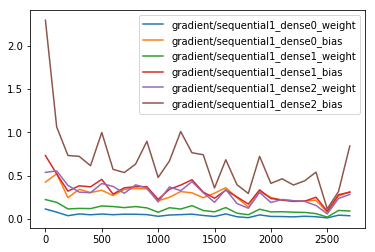

In [25]:
plot_gradients(good_trial)

We can also print inputs and outputs from the model. For instance, let's print the 83th sample of the 2700th batch, as seen by the network. 

Notice that we have to reshape the input data from a (784,) array to a (28,28) array and multiply by 255 - the exact inverse of the transformation we did above.

In [28]:
# The raw tensor
raw_t = good_trial.tensor('sequential0_input_0').step(2700).value[83]
# We have to undo the transformations in 'transformer' above. First of all, multiply by 255
raw_t = raw_t * 255
# Then reshape from a 784-long vector to a 28x28 square.
input_image = raw_t.reshape(28,28)
plt.imshow(input_image, cmap=plt.get_cmap('gray'))
plt.show()

AttributeError: 'NoneType' object has no attribute 'step'

We can also plot the relative values emitted by the network. Notice that the last layer is of type `Dense(10)`: it will emit 10 separate confidences, one for each 0-9 digit. The one with the highest output is the predicted value.

We can capture and plot the network output for the same sample.

In [27]:
plt.plot(good_trial.tensor('sequential0_output').step(2700).value[83], 'bo')
plt.show()
print( 'The network predicted the value: {}'.format(np.argmax(good_trial.tensor('sequential0_output').step(2700).value[83])))

AttributeError: 'NoneType' object has no attribute 'step'

### Vanishing Gradient

We have now worked through some of the basics. Let's pretend we are debugging a real problem: the [Vanishing Gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). When training a network, if the `learning_rate` is too high we will end up with a Vanishing Gradient. Let's set `learning_rate=1`.

Notice how the accuracy remains at around ~10% - no better than random.

In [19]:
# Temporary bug workaround, we will remove soon
from tornasole.mxnet.mxnet_collection import CollectionManager
from tornasole.mxnet import mxnet_collection
mxnet_collection._collection_manager = CollectionManager(create_default=False)

In [20]:
net = create_net( tornasole_save_interval=100, base_loc='./ts_output/', run_id='bad')
train(net=net, epochs=4, ctx=mx.cpu(), learning_rate=1, momentum=0.9)

[Epoch 0 Batch 100] Training: accuracy=0.115644
[Epoch 0 Batch 200] Training: accuracy=0.109701
[Epoch 0 Batch 300] Training: accuracy=0.105880
[Epoch 0 Batch 400] Training: accuracy=0.104339
[Epoch 0 Batch 500] Training: accuracy=0.103653
[Epoch 0] Training: accuracy=0.103467
[Epoch 0] Validation: accuracy=0.100900
[Epoch 1 Batch 100] Training: accuracy=0.108713
[Epoch 1 Batch 200] Training: accuracy=0.104080
[Epoch 1 Batch 300] Training: accuracy=0.103588
[Epoch 1 Batch 400] Training: accuracy=0.103641
[Epoch 1 Batch 500] Training: accuracy=0.102555
[Epoch 1] Training: accuracy=0.102350
[Epoch 1] Validation: accuracy=0.101000
[Epoch 2 Batch 100] Training: accuracy=0.099406
[Epoch 2 Batch 200] Training: accuracy=0.100597
[Epoch 2 Batch 300] Training: accuracy=0.100332
[Epoch 2 Batch 400] Training: accuracy=0.100299
[Epoch 2 Batch 500] Training: accuracy=0.101058
[Epoch 2] Training: accuracy=0.101033
[Epoch 2] Validation: accuracy=0.102800
[Epoch 3 Batch 100] Training: accuracy=0.09861

In [21]:
bad_trial = LocalTrial( 'myrun', './ts_output/bad/')

INFO:tornasole:Loading trial myrun at path ./ts_output/bad/
INFO:tornasole:Loaded 4 collections
INFO:tornasole:Loading 28 new steps


We can plot the gradients - notice how every single one of them (apart from one) goes to zero and stays there!

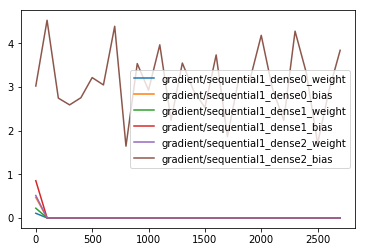

In [22]:
plot_gradients(bad_trial)

The `VanishingGradient` rule provided by Tornasole alerts for this automatically.

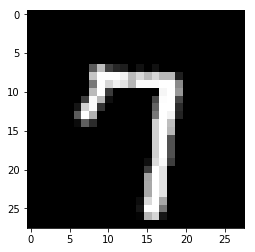

In [23]:
input_image = (bad_trial.tensor('sequential1_input_0').step(2700).value[83]*255).reshape(28,28)
plt.imshow(input_image, cmap=plt.get_cmap('gray'))
plt.show()

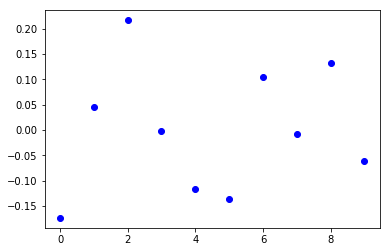

The network predicted the value: 2


In [24]:
plt.plot(bad_trial.tensor('sequential1_output').step(2700).value[83], 'bo')
plt.show()
print( 'The network predicted the value: {}'.format(np.argmax(bad_trial.tensor('sequential1_output').step(2700).value[83])))

## Data Analysis - Automatic
So far we have conducted a human analysis, but the real power of Tornasole comes from having automatic monitoring of training runs. To do so we will build a SageMaker-based system that monitors existing runs in real time. Data traces deposited in S3 are the exchange mechanism: 
- the training system deposits data into s3://mybucket/myrun/
- the monitoring system watches and reads data from s3://mybucket/myrun/

In this example we will simulate reading from that.

In [25]:
from tornasole.rules.generic import VanishingGradient
from tornasole.rules.rule_invoker import invoke_rule

In [26]:
vr = VanishingGradient(base_trial=good_trial, threshold=0.0001)
invoke_rule(vr, end_step=2700)

INFO:tornasole:Vanishing Gradient rule created with threshold: 0.000100
INFO:tornasole:Started execution of rule VanishingGradient
INFO:tornasole:Step 0 had 0 vanishing gradients
INFO:tornasole:Step 100 had 0 vanishing gradients
INFO:tornasole:Step 200 had 0 vanishing gradients
INFO:tornasole:Step 300 had 0 vanishing gradients
INFO:tornasole:Step 400 had 0 vanishing gradients
INFO:tornasole:Step 500 had 0 vanishing gradients
INFO:tornasole:Step 600 had 0 vanishing gradients
INFO:tornasole:Step 700 had 0 vanishing gradients
INFO:tornasole:Step 800 had 0 vanishing gradients
INFO:tornasole:Step 900 had 0 vanishing gradients
INFO:tornasole:Step 1000 had 0 vanishing gradients
INFO:tornasole:Step 1100 had 0 vanishing gradients
INFO:tornasole:Step 1200 had 0 vanishing gradients
INFO:tornasole:Step 1300 had 0 vanishing gradients
INFO:tornasole:Step 1400 had 0 vanishing gradients
INFO:tornasole:Step 1500 had 0 vanishing gradients
INFO:tornasole:Step 1600 had 0 vanishing gradients
INFO:tornasole

In [27]:
vr_bad = VanishingGradient(base_trial=bad_trial, threshold=0.0001)
invoke_rule(vr_bad, end_step=2700)

INFO:tornasole:Vanishing Gradient rule created with threshold: 0.000100
INFO:tornasole:Started execution of rule VanishingGradient
INFO:tornasole:Step 0 had 0 vanishing gradients
INFO:tornasole:Step 100 had 5 vanishing gradients
INFO:tornasole:Step 200 had 5 vanishing gradients
INFO:tornasole:Step 300 had 5 vanishing gradients
INFO:tornasole:Step 400 had 5 vanishing gradients
INFO:tornasole:Step 500 had 5 vanishing gradients
INFO:tornasole:Step 600 had 5 vanishing gradients
INFO:tornasole:Step 700 had 5 vanishing gradients
INFO:tornasole:Step 800 had 5 vanishing gradients
INFO:tornasole:Step 900 had 5 vanishing gradients
INFO:tornasole:Step 1000 had 5 vanishing gradients
INFO:tornasole:Step 1100 had 5 vanishing gradients
INFO:tornasole:Step 1200 had 5 vanishing gradients
INFO:tornasole:Step 1300 had 5 vanishing gradients
INFO:tornasole:Step 1400 had 5 vanishing gradients
INFO:tornasole:Step 1500 had 5 vanishing gradients
INFO:tornasole:Step 1600 had 5 vanishing gradients
INFO:tornasole

This concludes this notebook. For more information see the documentation at  
- https://github.com/awslabs/tornasole_core
